## Analyse the bandstructures

In [11]:
%aiida

Loaded AiiDA DB environment - profile name: quicksetup.

In [12]:
from pymatgen.electronic_structure.bandstructure import BandStructureSymmLine, Spin
from sumo.plotting.bs_plotter import SBSPlotter

def get_sumo_bands_plotter(bands, efermi=None, structure=None, **kwargs):
    """
    Return a sumo `SBSPlotter` object

    Arguments:
        bands_node: A BandsData object
        structure (optionsal): a StructureData object, required if `bands_node`
          does not have information about the cell.
        efermi (float): Explicit value of the fermi energy.

    Returns:
        A `SBSPlotter` object
    """
    bands_structure = get_pmg_bandstructure(bands, efermi=efermi, structure=structure, **kwargs)
    return SBSPlotter(bands_structure)
def get_pmg_bandstructure(bands_node, structure=None, efermi=None, **kwargs):
    """
    Return a pymatgen `BandStructureSymmLine` object from BandsData

    Arguments:
        bands_node: A BandsData object
        structure (optionsal): a StructureData object, required if `bands_node`
          does not have information about the cell.
        efermi (float): Explicit value of the fermi energy.

    Returns:
        A `BandStructureSymmLine` object
    """
    from aiida.orm import BandsData
    from pymatgen.core import Lattice
    
    if not isinstance(bands_node, BandsData):
        raise ValueError('The input argument must be a BandsData')
    # Load the data
    bands = bands_node.get_array('bands')  # In (num_spin, kpoints, bands) or just (kpoints, bands)
    kpoints = bands_node.get_array('kpoints')  # in (num_kpoints, 3)
    try:
        occupations = bands_node.get_array('occupations')
    except (KeyError, AttributeError):
        occupations = None

    try:
        efermi_raw = bands_node.get_attribute('efermi')
    except (KeyError, AttributeError):
        efermi_raw = None

    if efermi:
        efermi_raw = efermi

    labels = bands_node.get_attribute('labels')
    label_numbers = bands_node.get_attribute('label_numbers')

    # Construct the band_dict
    bands_shape = bands.shape
    if len(bands_shape) == 3:
        if bands_shape[0] == 2:
            bands_dict = {
                Spin.up: bands[0].T,  # Have to be (bands, kpoints)
                Spin.down:
                    bands[1].T  # Have to be (bands, kpoints)
            }
        else:
            bands_dict = {
                Spin.up: bands[0].T,  # Have to be (bands, kpoints)
            }
    else:
        bands_dict = {Spin.up: bands.T}

    if 'cell' in bands_node.attributes_keys():
        lattice = Lattice(bands_node.get_attribute('cell'))
    else:
        lattice = Lattice(structure.cell)

    # Constructure the label dictionary
    labels_dict = {}
    for label, number in zip(make_latex_labels(labels), label_numbers):
        labels_dict[label] = kpoints[number]

    # get the efermi
    if efermi_raw is None:
        if occupations is not None:
            efermi = find_vbm(bands, occupations)
        else:
            efermi = 0
            warnings.warn('Cannot find fermi energy - setting it to 0, this is probably wrong!')
    else:
        efermi = efermi_raw

    bands_structure = BandStructureSymmLine(kpoints,
                                            bands_dict,
                                            lattice.reciprocal_lattice,
                                            efermi=efermi,
                                            labels_dict=labels_dict,
                                            **kwargs)
    return bands_structure

def make_latex_labels(labels: list) -> list:
    """Convert labels to laxtex style"""
    label_mapping = {
        'GAMMA': r'\Gamma',
        'LAMBDA': r'\Lambda',
        'SIGMA': r'\Sigma',
    }
    out_labels = []
    for label in labels:
        for tag, replace in label_mapping.items():
            if tag in label:
                label = label.replace(tag, replace)
                break
        out_labels.append(f'{label}')
    return out_labels

def find_vbm(bands, occupations, tol=1e-4):
    """
    Find the fermi energy, put it at the top of VBM
    NOTE: this differs from the fermi energy reported in VASP when there is any
    electronic smearing.
    """
    return bands[occupations > tol].max()

In [13]:
from pymatgen.electronic_structure.bandstructure import Spin

## Manual plots



In [14]:
from matplotlib.style import use

Text(0.5, 1.0, '$P2_12_12_1$')

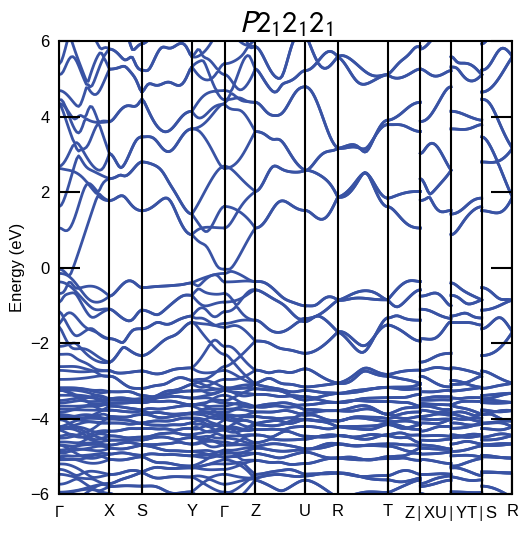

In [15]:
node = load_node("657dec8f-0f61-4a9a-b1d4-5caf9256667a")  # PBESol U=0
plotter = get_sumo_bands_plotter(node.outputs.band_structure)
if plotter.bs.is_spin_polarized:
    spin = Spin.up
else:
    spin = None
p = plotter.get_plot(dpi=100, spin=None, style = {'xtick.minor.size': 7.5, 'font.size': 12})
p.title(r'$P2_12_12_1$')

Text(0.5, 1.0, '$P2_12_12_1$ HSE06')

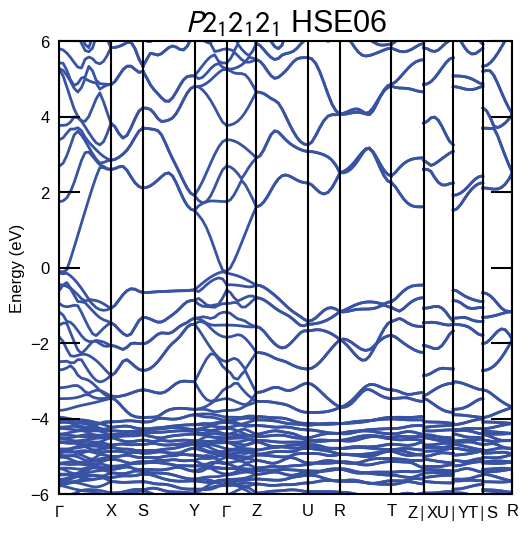

In [16]:
node = load_node("35d4c7f8-abf7-4d36-9282-a0f2985ae747")  # HSE06 - no SOC
plotter = get_sumo_bands_plotter(node.outputs.band_structure)
#plotter.bs.efermi = 5.28727157
if plotter.bs.is_spin_polarized:
    spin = Spin.up
else:
    spin = None
p = plotter.get_plot(dpi=100, spin=None, style = {'xtick.minor.size': 7.5, 'font.size': 12})
p.title(r'$P2_12_12_1$ HSE06')

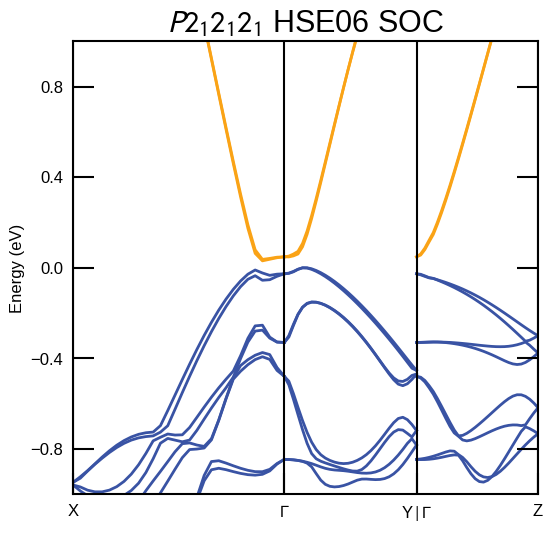

In [17]:
node = load_node("a03a6b22-8b6c-4ce7-8a54-f757e935dabe")
eferim = 5.30343861  # Manually pass the fermi energy as VBM is not correctly determinted due to fractional occupation and narrow gap
plotter = get_sumo_bands_plotter(node.outputs.band_structure, efermi=5.30343861, structure=node.inputs.structure)

if plotter.bs.is_spin_polarized:
    spin = Spin.up
else:
    spin = None
p = plotter.get_plot(dpi=100, spin=None, style = {'xtick.minor.size': 7.5, 'font.size': 12})
p.title(r'$P2_12_12_1$ HSE06 SOC')
p.ylim(-1, 1)
p.gca().set_aspect('auto')

Text(0.5, 1.0, 'anti-$\\mathrm{PbCl_2}$ PBEsol')

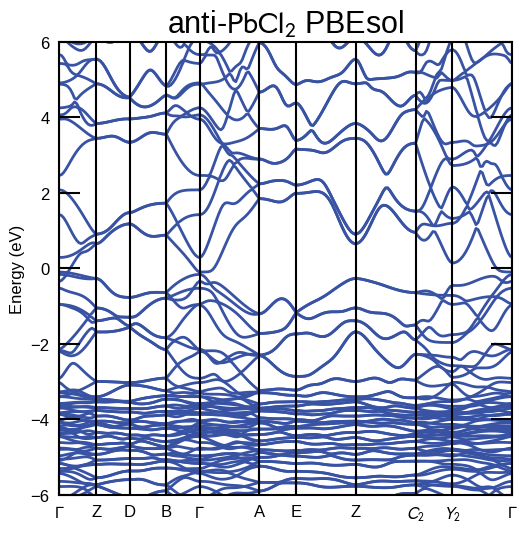

In [18]:
node = load_node("8e8bbcea-dee1-4ac4-8b6e-27743c370250")  # Anti PbCl usnig PBEsol
plotter = get_sumo_bands_plotter(node.outputs.band_structure)
if plotter.bs.is_spin_polarized:
    spin = Spin.up
else:
    spin = None
p = plotter.get_plot(dpi=100, spin=None, style = {'xtick.minor.size': 7.5, 'font.size': 12})
p.title(r'anti-$\mathrm{PbCl_2}$ PBEsol')

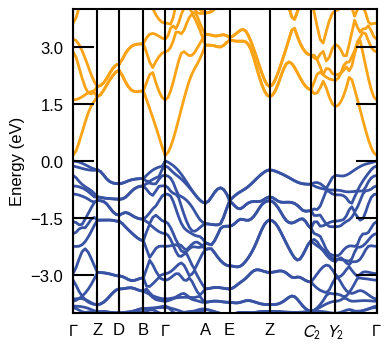

In [19]:
node = load_node("4fc13bc7-408a-4844-97ce-1d42a67c1491")
efermi = 5.19377654  # Manually pass the fermi energy as VBM is not correctly determinted due to fractional occupation and narrow gap
plotter = get_sumo_bands_plotter(node.outputs.band_structure, efermi=efermi)
if plotter.bs.is_spin_polarized:
    spin = Spin.up
else:
    spin = None
p = plotter.get_plot(dpi=100, spin=spin, style = {'xtick.minor.size': 7.5, 'font.size': 12}, width=4, height=4, ymin=-4, ymax=4)
#p.title(r'anti-PbCl HSE06')
p.tight_layout()
p.savefig('anti-pbcl-bs.svg')

In [ ]:
node = load_node("e58ebd97-79fb-4d68-a318-1767b1e7c8ea")
efermi = 5.21060246
plotter = get_sumo_bands_plotter(node.outputs.band_structure, structure=node.inputs.structure, efermi=efermi)
if plotter.bs.is_spin_polarized:
    spin = Spin.up
else:
    spin = None
p = plotter.get_plot(dpi=100, spin=spin, style = {'xtick.minor.size': 7.5, 'font.size': 12})
p.title(r'anti-PbCl HSE06 SOC')
p.ylim(-1, 1)
print(plotter.bs.get_band_gap())
p.gca().set_aspect('auto')
p.savefig('anti-pbcl-bs-soc.svg')

## Collection of UUIDs

In [ ]:
bands_uuids = [
    "657dec8f-0f61-4a9a-b1d4-5caf9256667a",
    "35d4c7f8-abf7-4d36-9282-a0f2985ae747",
    "a03a6b22-8b6c-4ce7-8a54-f757e935dabe",
    "8e8bbcea-dee1-4ac4-8b6e-27743c370250",
    "4fc13bc7-408a-4844-97ce-1d42a67c1491",
    "e58ebd97-79fb-4d68-a318-1767b1e7c8ea",
]